<a href="https://colab.research.google.com/github/antonfrancois/Demeter_metamorphosis/blob/experiment%2Fsimplex_pixyl/simplex_pixyl/examples/pixyl_param_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone --branch experiment/simplex_pixyl https://github.com/antonfrancois/Demeter_metamorphosis.git

Cloning into 'Demeter_metamorphosis'...
remote: Enumerating objects: 4996, done.
remote: Counting objects: 100% (1293/1293), done.
remote: Compressing objects: 100% (590/590), done.
remote: Total 4996 (delta 869), reused 1042 (delta 668), pack-reused 3703 (from 1)
Receiving objects: 100% (4996/4996), 602.80 MiB | 17.56 MiB/s, done.
Resolving deltas: 100% (3204/3204), done.
Updating files: 100% (161/161), done.


In [9]:
import subprocess

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/


print("\nInstalation of demeter from pip")
!pip install -e .

# !git fetch
# !git checkout experiment/simplex_pixyl


Instalation of demeter from pip
Obtaining file:///content/Demeter_metamorphosis
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for demeter_metamorphosis (pyproject.toml) ... done
  Created wheel for demeter_metamorphosis: filename=demeter_metamorphosis-0.2.9-0.editable-py3-none-any.whl size=4332 sha256=029cbf0ce702217ae68d6305fe023c6adbd54ec2e9fde35ecfed4be33529b2d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghk9df7k/wheels/c7/71/aa/4dfac81c8e26328effd94ced03987bdc69e149508d2e247f6c
Successfully built demeter_metamorphosis
  Attempting uninstall: demeter_metamorphosis
    Found existing installation: demeter_metamorphosis 0.2.9
    Uninstalling demeter_metamorphosis-0.2.9:
      Successfully uninstalled demeter_metamorphosis-0.2.9


M	pyproject.toml
Already on 'experiment/simplex_pixyl'
Your branch is up to date with 'origin/experiment/simplex_pixyl'.


In [5]:
import sys
import os

# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier

repo_path = os.path.abspath('.')
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)

['/content/Demeter_metamorphosis', '/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython']


# imports

In [8]:
from matplotlib import pyplot as plt

import __init__
import os, math, time
import sys, csv
import torch

import demeter.utils.reproducing_kernels as rk
import demeter.metamorphosis as mt
from demeter.constants import ROOT_DIRECTORY
import examples.pixyl_utils as pu
from demeter.utils.toolbox import convert_bytes_size
import demeter.utils.image_3d_plotter as i3p


ModuleNotFoundError: No module named 'demeter'

In [ ]:
def perform_simplex_ref(source, target, save_gpu):



    # if 'turtlefox' in ROOT_DIRECTORY:
    #     plot_simplex(source, slc)



    # subdiv = 10
    # sigma = rk.get_sigma_from_img_ratio(source.shape,subdiv = subdiv)
    # kernelOperator = rk.GaussianRKHS(sigma, kernel_reach=6, normalized=True)

    # sigma = (.01,.01,.1)
    # dx = tuple([1./(s-1) for s in source.shape[2:]])
    # kernelOperator = rk.VolNormalizedGaussianRKHS(
    #     sigma,
    #     sigma_convention="continuous",
    #     dx=dx,
    #     kernel_reach=6
    # )

    sigma = (.1,.1,.1)
    dx = tuple([1./(s-1) for s in source.shape[2:]])
    # dx = (1, 1, 1)
    k = 3
    kernelOperator = rk.All_Scale_Anisotropic_Normalized_Gaussian_RKHS(
            sigma=sigma,
            k = k,
            dx=dx,
            sigma_convention='continuous'
        )


    print(kernelOperator)
    print(kernelOperator.kernel.max())
    # rk.plot_gaussian_kernel_3d(kernelOperator.kernel, sigma=sigma)
    # plt.show()



    data_cost = mt.Ssd_normalized(target)
    # data_cost = None
    dx_convention = "pixel"
    source = source.to(device)
    target = target.to(device)

    print("source", source.min(), source.max())
    rho = 1
    ic(rho)

    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.synchronize()

    try:
        start = time.time()

        # from torch.profiler import profile, record_function, ProfilerActivity

        # with profile(
        #     activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        #     profile_memory=True
        # ) as prof:
        #     with record_function("simplex_metamorphosis"):
        mr = mt.simplex_metamorphosis(source, target, 0,
                        rho= rho,
                       kernelOperator=kernelOperator,
                        data_term=data_cost,
                       cost_cst=.001,
                       integration_steps=10,
                       n_iter=5,
                       grad_coef=10,
                      dx_convention=dx_convention,
                      save_gpu_memory=save_gpu,
                    lbfgs_history_size = 5
        )
        ic(mr)
        torch.cuda.synchronize()
        exec_time = time.time() - start
        mem_usage = torch.cuda.max_memory_allocated()
        # print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

        print('-_'*15)
        print("size : ",source.shape,  "save gpu", save_gpu)
        print("memory used : " ,convert_bytes_size(mem_usage))
        print('-_'*15)
        print("\n")
    except torch.OutOfMemoryError:
        print("OUT OF MEMORY")
        return None, None, None,  source.shape

    return mr, mem_usage, exec_time, source.shape


    #%%
def plot_mr(mr, slice, resize_factor):
    slc = tuple( [int(s * r) for s, r in zip(slice, resize_factor)])
    rho = mr.mp.rho
    name = f"{patient}_{source_fol}_to_{target_fol}_meta_rho{rho}"
    if 'turtlefox' in ROOT_DIRECTORY:
        mr.plot_cost()
        plt.show()
        ic.disable()
        i3p.Visualize_GeodesicOptim_plt(mr, name)
        plt.show()
    else:
        out_path = os.path.join(
            "/gpfs/users/francoisa/RadioAide_Preprocessing",
            "imgs/pixyl_reg"
        )

        t_img = i3p.SimplexToHSV(mr.mp.image_stock.cpu(), is_last_background=True).to_rgb()
        ic(t_img.shape)
        # t = 4
        for t in range(t_img.shape[0]):
            fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(15,5))
            ax[0].imshow(t_img[t,:,:,slc[2]].transpose(1,0,2), aspect="auto", origin="lower")
            ax[1].imshow(t_img[t,:, slc[1], :].transpose(1,0,2), aspect="auto", origin="lower")
            ax[2].imshow(t_img[t,slc[0],:,:].transpose(1,0,2), aspect="auto", origin="lower")

            line_color = "red"
            _l_x_v = ax[0].axvline(x=slc[0], color=line_color, alpha=0.6)
            _l_x_h = ax[0].axhline(y=slc[1], color=line_color, alpha=0.6)
            _l_y_v = ax[1].axvline(x=slc[0], color=line_color, alpha=0.6)
            _l_y_h = ax[1].axhline(y=slc[2], color=line_color, alpha=0.6)
            _l_z_v = ax[2].axvline(x=slc[1], color=line_color, alpha=0.6)
            _l_z_h = ax[2].axhline(y=slc[2], color=line_color, alpha=0.6)

            title = name+ f" t = {t}"
            fig.suptitle(title, fontsize=20)
            fig.savefig(out_path+'/'+title+"_meso.png")
            plt.show()

    mr.save(name, light_save=True)


In [ ]:
device = 'cuda:0'
if 'turtlefox' in ROOT_DIRECTORY:
    path = "/home/turtlefox/Documents/11_metamorphoses/data/pixyl/aligned"
else:
    path = "/gpfs/workdir/francoisa/data/aligned"

rf = .2
resize_factor = (rf, rf, 1)

patient, my_slice  = "PSL_001", (200,270,50)
# patient, slice  = "PSL_007", (300,180,25)
source_fol = "M21"
target_fol = "M30"
# source_fol = "M10"
# target_fol = "M14"
rf_slice = tuple([s*r for s, r in zip(my_slice, resize_factor)])

save_gpu = True
source = pu.path_to_simplex(os.path.join(path,patient,f"{patient}_{source_fol}"),
                                resize_factors=resize_factor,
                                key = 'LB_prob'
                                )
target = pu.path_to_simplex(
    os.path.join(path,patient,f"{patient}_{target_fol}"),
    resize_factors=resize_factor,
    key = 'LB_prob'
)
print("source : ", source.shape, source.min().item(), source.max().item())
print("target; ", target.shape, target.min().item(), target.max().item())

	Adding : PSL_001_M21_to_PSL_001_LB_prob_necrosis.nii.gz
	Adding : PSL_001_M21_to_PSL_001_LB_prob_wm.nii.gz
	Adding : PSL_001_M21_to_PSL_001_LB_prob_basal.nii.gz
	Adding : PSL_001_M21_to_PSL_001_LB_prob_ventricles.nii.gz
	Adding : PSL_001_M21_to_PSL_001_LB_prob_gm.nii.gz
	Adding : PSL_001_M21_to_PSL_001_LB_prob_gde.nii.gz
	Adding : PSL_001_M21_to_PSL_001_LB_prob_thalamus.nii.gz
	Adding : PSL_001_M21_to_PSL_001_LB_prob_wmh_edema.nii.gz
	 len(proba_f) 8
	Adding : PSL_001_M30_to_PSL_001_LB_prob_necrosis.nii.gz
	Adding : PSL_001_M30_to_PSL_001_LB_prob_wm.nii.gz
	Adding : PSL_001_M30_to_PSL_001_LB_prob_basal.nii.gz
	Adding : PSL_001_M30_to_PSL_001_LB_prob_ventricles.nii.gz
	Adding : PSL_001_M30_to_PSL_001_LB_prob_gm.nii.gz
	Adding : PSL_001_M30_to_PSL_001_LB_prob_gde.nii.gz
	Adding : PSL_001_M30_to_PSL_001_LB_prob_thalamus.nii.gz
	Adding : PSL_001_M30_to_PSL_001_LB_prob_wmh_edema.nii.gz
	 len(proba_f) 8
source :  torch.Size([1, 9, 76, 76, 100]) 0.0 1.0
target;  torch.Size([1, 9, 76, 76, 100

In [ ]:
mr, mem, time_exec, img_shape = perform_simplex_ref(source, target, save_gpu)


(3,)
All_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
	sigma=tensor([7.5000, 7.5000, 9.9000]),
	sigma_continuous=tensor([0.1000, 0.1000, 0.1000]),
	 k=3,
	 dx=(0.013333333333333334, 0.013333333333333334, 0.010101010101010102),
	 kernel_size=torch.Size([1, 37, 37, 49])
)
tensor(0.1099)
source 

/tmp/ipykernel_49447/3735869169.py:50: RuntimeWarning: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  ic(rho)
ic| 3735869169.py:50 in perform_simplex_ref()- 1


tensor(0., device='cuda:0', dtype=torch.float64) tensor(1., device='cuda:0', dtype=torch.float64)
Progress: [####------]  40.00%  (Ssd_normalized : ,  0.0318).
Progress: [######----]  60.00%  (Ssd_normalized : ,  0.0296).
Progress: [########--]  80.00%  (Ssd_normalized : ,  0.0278).
Progress: [##########] 100.00% Done...
 (Ssd_normalized : ,  0.0271).


/home/turtlefox/anaconda3/envs/demeter_env/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/tmp/ipykernel_49447/3735869169.py:78: RuntimeWarning: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  ic(mr)
ic| 3735869169.py:78 in perform_simplex_ref()
    Simplex_sqrt_Shooting(cost_parameters : {, 
    		rho =1, 
    		lambda =0.001
    	},
    	geodesic integrator : Simplex_srqt_Metamorphosis_integrator(
    	rho=1,
    	kernelOperator=All_Scale_Anisotropic_Normalized_Gaussian_RKHS+            (
    	sigma=tensor([7.5000, 7.5000, 9.9000], device='cuda:0'),
    	sigma_continuous=tensor([0.1000, 0.1000, 0.1000], device='cuda:0'),
    	 k=3,
    	 dx=(0.013333333333333334, 0.013333333333333334, 0.0101010101


Computation of forward done in  0:01:21s and 0.315cents  s
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
size :  torch.Size([1, 9, 76, 76, 100]) save gpu True
memory used :  2.77 GB
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_




(1, 76, 76, 100, 3)
img_3D.shape :  (76, 76, 100, 3)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)


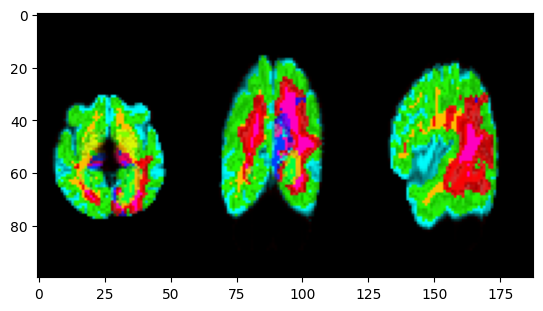

In [ ]:
from demeter.constants import set_ticks_off
import demeter.utils.torchbox as tb
import numpy as np

def make_3d_flat(img_3D, slice):
    print("img_3D.shape : ",img_3D.shape)
    if len(img_3D.shape) == 4:
        img_list = [make_3d_flat(img_3D[...,i],slice) for i in range(img_3D.shape[-1])]
        return np.stack(img_list, axis=-1)
    elif len(img_3D.shape) != 3:
        raise ValueError(f"img_3D has wrong shape: {img_3D.shape}")


    im0 = tb.image_slice(img_3D, slice[0], 2).T
    im1 = tb.image_slice(img_3D, slice[1], 1).T
    im2 = tb.image_slice(img_3D, slice[2], 0).T

    crop = 20
    im0_np = im0
    im1_np = im1[::-1]
    im2_np = im2[::-1]

    # On réduit uniquement si nécessaire
    im0_np = im0_np[:, crop // 2: -crop // 2] if crop < im0_np.shape[1] else im0_np
    im1_np = im1_np[:, crop // 2: -crop // 2] if crop < im1_np.shape[1] else im1_np
    im2_np = im2_np[:, crop // 2:] if crop < im2_np.shape[1] else im2_np

    # Nouvelle largeur totale plus souple
    W0 = im0_np.shape[1]
    W1 = im1_np.shape[1]
    W2 = im2_np.shape[1]
    new_width = W0 + W1 + W2 + 10  # marges

    max_height = max(im0_np.shape[0], im1_np.shape[0], im2_np.shape[0])
    long_img = np.zeros((max_height, new_width))

    # Placement
    x0 = 0
    x1 = x0 + W0 + 5
    x2 = x1 + W1 + 5

    y0 = (max_height - im0_np.shape[0]) // 2
    y1 = (max_height - im1_np.shape[0]) // 2
    y2 = (max_height - im2_np.shape[0]) // 2

    long_img[y0:y0 + im0_np.shape[0], x0:x0 + W0] = im0_np
    long_img[y1:y1 + im1_np.shape[0], x1:x1 + W1] = im1_np
    long_img[y2:y2 + im2_np.shape[0], x2:x2 + W2] = im2_np

    return long_img




coord = -1
img_3D = mr.mp.image_stock[coord][None]
img_3D_rgb = i3p.SimplexToHSV(img_3D, is_last_background=True).to_rgb()
print(img_3D_rgb.shape)
long_img= make_3d_flat(img_3D_rgb[0],rf_slice)

plt.imshow(long_img, cmap='gray')
plt.show()
# img_3D = mr.mp.image_stock
# img_3D_rgb = i3p.SimplexToHSV(img_3D, is_last_background=True).to_rgb()

img_3D.shape :  (76, 76, 100, 3)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100, 3)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100, 3)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100, 3)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100, 3)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100, 3)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)
img_3D.shape :  (76, 76, 100)


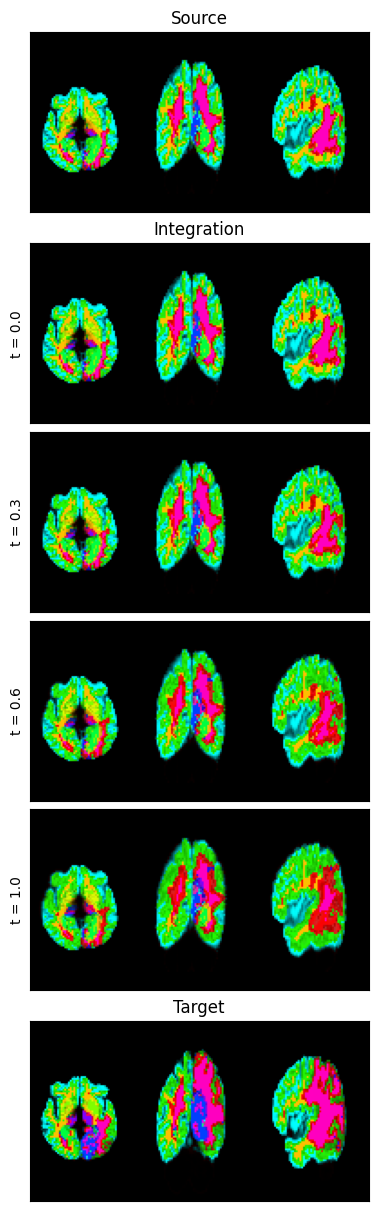

In [ ]:
# %matplotlib qt
# plot_mr(mr, slice, resize_factor)
#


def make_integration_fig(subfig,mr,slice,n_plots=4,
                         show_source_target= True,
                         ylabel=True,
                         cmp_mask=False):
    sst = show_source_target
    ax = subfig.subplots(n_plots+2*sst,1)
    set_ticks_off(ax)
    title = 'Mask evolution' if cmp_mask else 'Integration'
    ax[0 + 1*sst].set_title(title)

    img_3D_rgb = i3p.SimplexToHSV(mr.mp.image_stock, is_last_background=True).to_rgb()
    for i in range(n_plots):
        coord = i*(mr.mp.n_step-1)//(n_plots-1)
        long_img= make_3d_flat(img_3D_rgb[coord],slice)

        ax[i+1*sst].imshow(long_img,cmap='gray',vmin=0,vmax=1)
        if ylabel:
            ax[i+1*sst].set_ylabel(f"t = {(i*mr.mp.n_step//(n_plots-1))/mr.mp.n_step}")
    if sst:
        source_flat = make_3d_flat(
            i3p.SimplexToHSV(mr.source, is_last_background=True).to_rgb()[0]
            ,slice
        )
        target_flat = make_3d_flat(
            i3p.SimplexToHSV(mr.target, is_last_background=True).to_rgb()[0]
            ,slice
        )

        ax[0].imshow(source_flat,cmap='gray',vmin=0,vmax=1)
        ax[0].set_title('Source')
        ax[-1].imshow(target_flat,cmap='gray',vmin=0,vmax=1)
        ax[-1].set_title('Target')
    return ax
ic.disable()
fig = plt.figure(figsize=(12,12),constrained_layout = True)
ax = make_integration_fig(fig,mr,rf_slice,show_source_target=True,n_plots=4)
